# Experiment Data

### Todo
- Speed plots
- find max speed for continuity checks
- number of visits to arbitrary area

### problems
- undistort_point is not working with the reinforced location
- something looks off with the undistort_data of some sessions (see Test pv20_exp9_20210531_120417)

In [1]:
import os
import sys
os.chdir('/home/tal/dev/reptilearn/system')
sys.path.append('/home/tal/dev/reptilearn/analysis')
import analysis
from pathlib import Path
import pandas as pd
import numpy as np
import undistort
import re
import cv2 as cv
import pprint as pp
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import visualize
import bbox
import moviepy.video.io.ffmpeg_tools as ff
import copy
import math
from tqdm.auto import tqdm

## Reload

In [2]:
importlib.reload(analysis)
importlib.reload(undistort)

<module 'undistort' from '/home/tal/dev/reptilearn/system/undistort.py'>

In [3]:
config = analysis.load_config("config")

In [18]:
pd.set_option('display.max_rows', 500)
exps = analysis.list_experiments(config.experiment_data_root)
index = exps.index
exps = pd.concat([exps.reset_index(drop=True), analysis.experiment_stats_df(exps)], axis=1)
exps.index = index

In [5]:
# n most recent experiments
n = 10
exps.sort_index(ascending=False).head(n)

name  \
2021-07-24 14:27:07    video_test   
2021-07-21 10:31:44  pv20_noaruco   
2021-07-19 18:54:02      loclearn   
2021-07-19 12:09:54          pv20   
2021-07-18 13:29:13  vstim_pv4_08   
2021-07-18 13:23:17  vstim_pv4_07   
2021-07-18 13:17:21  vstim_pv4_06   
2021-07-18 13:12:03  vstim_pv4_05   
2021-07-18 13:08:06  vstim_pv4_04   
2021-07-18 13:03:12  vstim_pv4_03   

                                                                   dir  \
2021-07-24 14:27:07  /data/reptilearn/experiments/video_test_202107...   
2021-07-21 10:31:44  /data/reptilearn/experiments/pv20_noaruco_2021...   
2021-07-19 18:54:02  /data/reptilearn/experiments/loclearn_20210719...   
2021-07-19 12:09:54  /data/reptilearn/experiments/pv20_20210719_120954   
2021-07-18 13:29:13  /data/reptilearn/experiments/vstim_pv4_08_2021...   
2021-07-18 13:23:17  /data/reptilearn/experiments/vstim_pv4_07_2021...   
2021-07-18 13:17:21  /data/reptilearn/experiments/vstim_pv4_06_2021...   
2021-07-18 13:12:03  /data/reptilearn/experiments/vstim_pv4_05_2021...   
2021-07-18 13:08:06  /data/reptilearn/experiments/vstim_pv4_04_2021...   
2021-07-18 13:03:12  /data/reptilearn/experiments/vstim_pv4_03_2021...   

                     video_count  image_count  csv_count  
2021-07-24 14:27:07            0            0          2  
2021-07-21 10:31:44            4            1          6  
2021-07-19 18:54:02            0            0          1  
2021-07-19 12:09:54            4            1          6  
2021-07-18 13:29:13            4            0          5  
2021-07-18 13:23:17            4            0          5  
2021-07-18 13:17:21            4            0          5  
2021-07-18 13:12:03            4            0          5  
2021-07-18 13:08:06            4            0          5  
2021-07-18 13:03:12            4            0          5

In [155]:
pv20 = exps[exps.name.str.startswith('pv20')]

In [156]:
for ts, exp in pv20.iterrows(): print(exp.dir)

/data/reptilearn/experiments/pv20_exp3_20210519_103530
/data/reptilearn/experiments/pv20_exp3_20210519_120403
/data/reptilearn/experiments/pv20_exp3_20210519_125353
/data/reptilearn/experiments/pv20_exp3_20210519_133447
/data/reptilearn/experiments/pv20_exp4_20210520_112511
/data/reptilearn/experiments/pv20_exp6_20210524_092130
/data/reptilearn/experiments/pv20_exp6_20210524_114758
/data/reptilearn/experiments/pv20_exp7_20210527_111256
/data/reptilearn/experiments/pv20_exp6_2_20210527_134505
/data/reptilearn/experiments/pv20_exp8_20210531_101857
/data/reptilearn/experiments/pv20_exp9_20210531_120417
/data/reptilearn/experiments/pv20_exp10_bottom_left_20210602_110241
/data/reptilearn/experiments/pv20_exp10_20210607_102406
/data/reptilearn/experiments/pv20_exp11_20210610_105209
/data/reptilearn/experiments/pv20_exp11_20210614_110403
/data/reptilearn/experiments/pv20_long_20210630_114712
/data/reptilearn/experiments/pv20_morning_20210701_070140
/data/reptilearn/experiments/pv20_morning_ch

# Extract event subclips

In [157]:
def analyze_experiment(exp):
    print(f"Experiment: {exp.name} {exp.dir}")
    info = analysis.load_timestamps(analysis.experiment_info(exp.dir))
    events = analysis.read_event_log(info)
    top_vids_info = analysis.find_src_videos(info, "top")
    
    # Create analysis dir if not exists.
    analysis_dir = exp.dir / "analysis" / "event_clips"
    
    if analysis_dir.exists():
        return
    
    analysis_dir.mkdir(exist_ok=True, parents=True)
    
    # Reward events
    event = 'arena/dispense_reward'
    reward_video_event_df = analysis.create_video_event_df(top_vids_info, events.query("event == @event"))
    print(reward_video_event_df)
    analysis.extract_event_clips(reward_video_event_df, analysis_dir, file_prefix='reward')

    """    
    # old event types 
    old_events = {
        "in_area": events[events.event.str.startswith("learn_exp") & events.value.str.contains("in radius")],
        "out_of_area_wait": events[events.event.str.startswith("learn_exp") & events.value.str.contains("out of radius, waiting")],
        "out_of_area_end_trial": events[events.event.str.startswith("learn_exp") & events.value.str.contains("out of radius, ended")]
    }
    
    # new event types 
    new_events = {
        "in_area": events[events.event.str.contains("in_radius")],
        "out_of_area_wait": events[events.event.str.contains("out_radius")],
        "out_of_area_end_trial": events[events.event.str.contains("logical_trial_ended")]            
    }
    
    pre_secs, post_secs = 5, 5

    for event_list in [old_events, new_events]:
        for event_name, events in event_list.items():
            _ = analysis.extract_event_clips(
                analysis.create_video_event_df(top_vids_info, events), 
                analysis_dir, 
                file_prefix=event_name,
                pre_secs=pre_secs,
                post_secs=post_secs,    
            )
    """
    

In [159]:
for ts, exp in tqdm(pv20.iterrows(), total=len(pv20)):
    try:
        analyze_experiment(exp)
    except Exception as e:
        print(e)

  0%|          | 0/26 [00:00<?, ?it/s]

Experiment: 2021-05-19 10:35:30 /data/reptilearn/experiments/pv20_exp3_20210519_103530
Experiment: 2021-05-19 12:04:03 /data/reptilearn/experiments/pv20_exp3_20210519_120403
Experiment: 2021-05-19 12:53:53 /data/reptilearn/experiments/pv20_exp3_20210519_125353
Experiment: 2021-05-19 13:34:47 /data/reptilearn/experiments/pv20_exp3_20210519_133447
Experiment: 2021-05-20 11:25:11 /data/reptilearn/experiments/pv20_exp4_20210520_112511
Experiment: 2021-05-24 09:21:30 /data/reptilearn/experiments/pv20_exp6_20210524_092130
Experiment: 2021-05-24 11:47:58 /data/reptilearn/experiments/pv20_exp6_20210524_114758
Experiment: 2021-05-27 11:12:56 /data/reptilearn/experiments/pv20_exp7_20210527_111256
Experiment: 2021-05-27 13:45:05 /data/reptilearn/experiments/pv20_exp6_2_20210527_134505
Experiment: 2021-05-31 10:18:57 /data/reptilearn/experiments/pv20_exp8_20210531_101857
Experiment: 2021-05-31 12:04:17 /data/reptilearn/experiments/pv20_exp9_20210531_120417
Experiment: 2021-06-02 11:02:41 /data/rep

# Head Position

In [160]:
infos = []
for i, (ts, exp) in enumerate(tqdm(pv20.iterrows(), total=len(pv20))):
    infos.append(analysis.load_timestamps(analysis.experiment_info(exp.dir)))

  0%|          | 0/26 [00:00<?, ?it/s]

In [161]:
cent_dfs = []

for info in tqdm(infos):
    if "head_bbox" in info:
        centroids = analysis.get_head_centroids(info, None) # config.undistort_flir_blackfly_computar)
        cent_df = pd.DataFrame(centroids, columns=["x", "y"])
        cent_dfs.append(cent_df)

  0%|          | 0/26 [00:00<?, ?it/s]

In [162]:
mapping, roi, newcamtx = undistort.get_undistort_mapping(1440, 1080, config.undistort_flir_blackfly_computar)

backgrounds = []

for info in infos:
    imgs = [p for p in info["images"] if "reinforced_area" in p.name]
    if len(imgs) > 0:
        img = cv.imread(str(imgs[0]))
        backgrounds.append(img)        
        # backgrounds.append(undistort.undistort_image(img, mapping))
    else:
        backgrounds.append(None)

In [163]:
durations = []
for info in infos:
    cams = [list(vid.values())[0] for vid in info["videos"].values()]
    durations.append(sum([cam["duration"] for cam in cams]))

  0%|          | 0/26 [00:00<?, ?it/s]

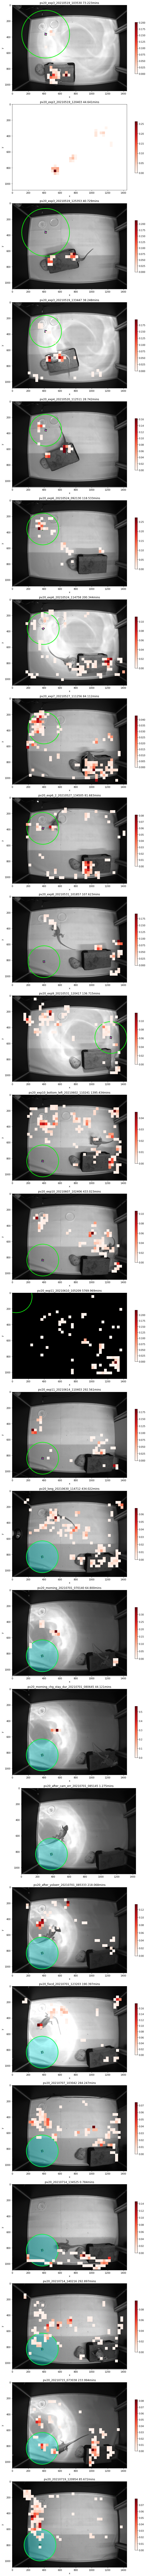

In [164]:
n = pv20.shape[0]
l = 1# math.ceil(math.sqrt(n))
sx = 10
sy = 6
fig, axs = plt.subplots(n//l, l, figsize=(sx*l, sy*n//l))
axs = axs.flatten()

for i, cent_df in enumerate(tqdm(cent_dfs)):
    ax = axs[i]

    sns.histplot(cent_df, x="x", y="y", cbar=True, stat="probability", cmap=sns.color_palette("Reds", as_cmap=True), ax=axs[i],
                 cbar_kws={"shrink": 0.6}, binwidth=32, thresh=0.0014)
    
    if infos[i]["session_state"] and "reinforced_location" in infos[i]["session_state"]:                
        state = infos[i]["session_state"]
        rloc = state["reinforced_location"]
        
        if "params" in state and "reward_radius" in state["params"]:
            r = state["params"]["reward_radius"]
            ax.add_patch(plt.Circle(rloc, r, color='cyan', alpha=0.3, zorder=-1))
        else:
            ax.add_patch(plt.Circle(rloc, 10, color='magenta', alpha=0.3, zorder=-1))
            
    #ax.scatter(cent_df.x, cent_df.y, alpha=0.1, s=1)
    if backgrounds[i] is not None:
        ax.imshow(backgrounds[i], zorder=-2)

        
    ax.set_title(f"{pv20.iloc[i].dir.name} {durations[i] / np.timedelta64(1, 'm'):.3f}mins")
    ax.axes.set_aspect('equal')
    ax.set_xlim(0, 1440)
    ax.set_ylim(0, 1080)
    ax.invert_yaxis()
    
fig.tight_layout()

# Test pv20_exp9_20210531_120417

In [344]:
exp = pv20.query("name == 'pv20_after_yoloerr'").iloc[0]

In [371]:
info = analysis.load_timestamps(analysis.experiment_info(exp.dir))

In [346]:
info

{'videos': {Timestamp('2021-07-01 08:53:34'): {'back': {'path': PosixPath('/data/reptilearn/experiments/pv20_after_yoloerr_20210701_085333/back_20210701-085334.mp4'),
    'timestamps': PosixPath('/data/reptilearn/experiments/pv20_after_yoloerr_20210701_085333/back_20210701-085334.csv'),
    'frame_count': 730537,
    'duration': numpy.timedelta64(13084084284305,'ns')},
   'left': {'path': PosixPath('/data/reptilearn/experiments/pv20_after_yoloerr_20210701_085333/left_20210701-085334.mp4'),
    'timestamps': PosixPath('/data/reptilearn/experiments/pv20_after_yoloerr_20210701_085333/left_20210701-085334.csv'),
    'frame_count': 730537,
    'duration': numpy.timedelta64(13084079704999,'ns')},
   'top': {'path': PosixPath('/data/reptilearn/experiments/pv20_after_yoloerr_20210701_085333/top_20210701-085334.mp4'),
    'timestamps': PosixPath('/data/reptilearn/experiments/pv20_after_yoloerr_20210701_085333/top_20210701-085334.csv'),
    'frame_count': 730537,
    'duration': numpy.timedelta6

In [349]:
centroids = analysis.get_head_centroids(info, config.undistort_flir_blackfly_computar)
dist_centroids = analysis.get_head_centroids(info, None)

(0.0, 1080.0)

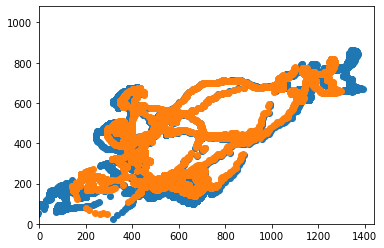

In [350]:
plt.scatter(x=centroids[:, 0], y=centroids[:, 1])
plt.scatter(x=dist_centroids[:, 0], y=dist_centroids[:, 1])
plt.xlim((0, 1440))
plt.ylim((0, 1080))

In [372]:
top_vids_info = analysis.find_src_videos(info, "top")

In [373]:
events = analysis.read_event_log(info)

In [374]:
es = events.query("event == 'loclearn/entered_area'")
ev_first = es.iloc[0]
ev_last = es.iloc[-1]
events = pd.DataFrame(data=[ev_first, ev_last])

In [375]:
vid_ev_df = analysis.create_video_event_df(top_vids_info, events)

In [376]:
vid_ev_df

path   frame  \
0  /data/reptilearn/experiments/pv20_after_yoloer...  600910   
1  /data/reptilearn/experiments/pv20_after_yoloer...  602198   

                      timestamp                   video_start  
0 2021-07-01 08:52:54.586266112 2021-07-01 05:53:35.059853824  
1 2021-07-01 08:53:17.620288000 2021-07-01 05:53:35.059853824

In [382]:
vid_path = list(top_vids_info.values())[0]["path"]

In [383]:
analysis.extract_clip(vid_path, vid_ev_df.iloc[0].frame - 3600, vid_ev_df.iloc[-1].frame + 3600, "../analysis/july1_consecutive_inout.mp4")

In [395]:
# add head bbox to this clip!

## Reinforced Area

In [165]:
ps = []

for info, cent_df in tqdm(zip(infos, cent_dfs), total=len(infos)):
    if info["session_state"] is not None and "reinforced_location" in info["session_state"]:
        state = info["session_state"]
        loc = state["reinforced_location"]
        
        if "params" in state and "reward_radius" in state["params"]:
            r2 = state["params"]["reward_radius"] ** 2
            dist2 = ((cent_df.values - loc) ** 2).sum(1)
            p = (dist2 < r2).sum() / len(cent_df)        
            ps.append(p)
        else:
            ps.append(None)
    else:
        ps.append(None)

  0%|          | 0/26 [00:00<?, ?it/s]

In [166]:
names = [r.dir.name for l, r in pv20.iterrows()]
list(zip(names, ps))

[('pv20_exp3_20210519_103530', None),
 ('pv20_exp3_20210519_120403', None),
 ('pv20_exp3_20210519_125353', None),
 ('pv20_exp3_20210519_133447', None),
 ('pv20_exp4_20210520_112511', None),
 ('pv20_exp6_20210524_092130', None),
 ('pv20_exp6_20210524_114758', None),
 ('pv20_exp7_20210527_111256', None),
 ('pv20_exp6_2_20210527_134505', None),
 ('pv20_exp8_20210531_101857', None),
 ('pv20_exp9_20210531_120417', None),
 ('pv20_exp10_bottom_left_20210602_110241', None),
 ('pv20_exp10_20210607_102406', None),
 ('pv20_exp11_20210610_105209', None),
 ('pv20_exp11_20210614_110403', None),
 ('pv20_long_20210630_114712', 0.002151494100775295),
 ('pv20_morning_20210701_070140', 0.0038334453147290818),
 ('pv20_morning_chg_stay_dur_20210701_080645', 0.0),
 ('pv20_after_cam_err_20210701_085145', 0.0),
 ('pv20_after_yoloerr_20210701_085333', 0.0013715937728000088),
 ('pv20_fixcd_20210701_123203', 0.0),
 ('pv20_20210707_103042', 0.007879540293628936),
 ('pv20_20210714_134525', 0.08689081979599547),
 (

In [167]:
list(zip(ps[-9:], names[-9:]))

[(0.0, 'pv20_morning_chg_stay_dur_20210701_080645'),
 (0.0, 'pv20_after_cam_err_20210701_085145'),
 (0.0013715937728000088, 'pv20_after_yoloerr_20210701_085333'),
 (0.0, 'pv20_fixcd_20210701_123203'),
 (0.007879540293628936, 'pv20_20210707_103042'),
 (0.08689081979599547, 'pv20_20210714_134525'),
 (0.06994902817453649, 'pv20_20210714_140216'),
 (0.14551952406816657, 'pv20_20210715_073038'),
 (0.07261836354455066, 'pv20_20210719_120954')]

Text(0.5, 0, 'probability')

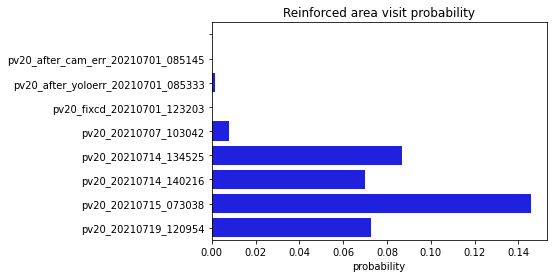

In [168]:
ax = sns.barplot(data=[None] + ps[-8:], orient="h", color='blue')
ax.set_title("Reinforced area visit probability")
ax.set_yticklabels([None] + names[-8:])
ax.set_xlabel("probability")
# normalize by movement?
# remove by speed threshold?

# Distance

In [187]:
dists = []

for info, cent_df in tqdm(zip(infos, cent_dfs), total=len(infos)):
    if info["session_state"] is not None and "reinforced_location" in info["session_state"]:
        state = info["session_state"]
        loc = state["reinforced_location"]

        if "params" in state and "reward_radius" in state["params"]:
            r2 = state["params"]["reward_radius"] ** 2
            dist = np.sqrt(((cent_df.values - loc) ** 2).sum(1))
            dists.append(dist)
        else:
            dists.append(None)
    else:
        dists.append(None)
    

  0%|          | 0/26 [00:00<?, ?it/s]

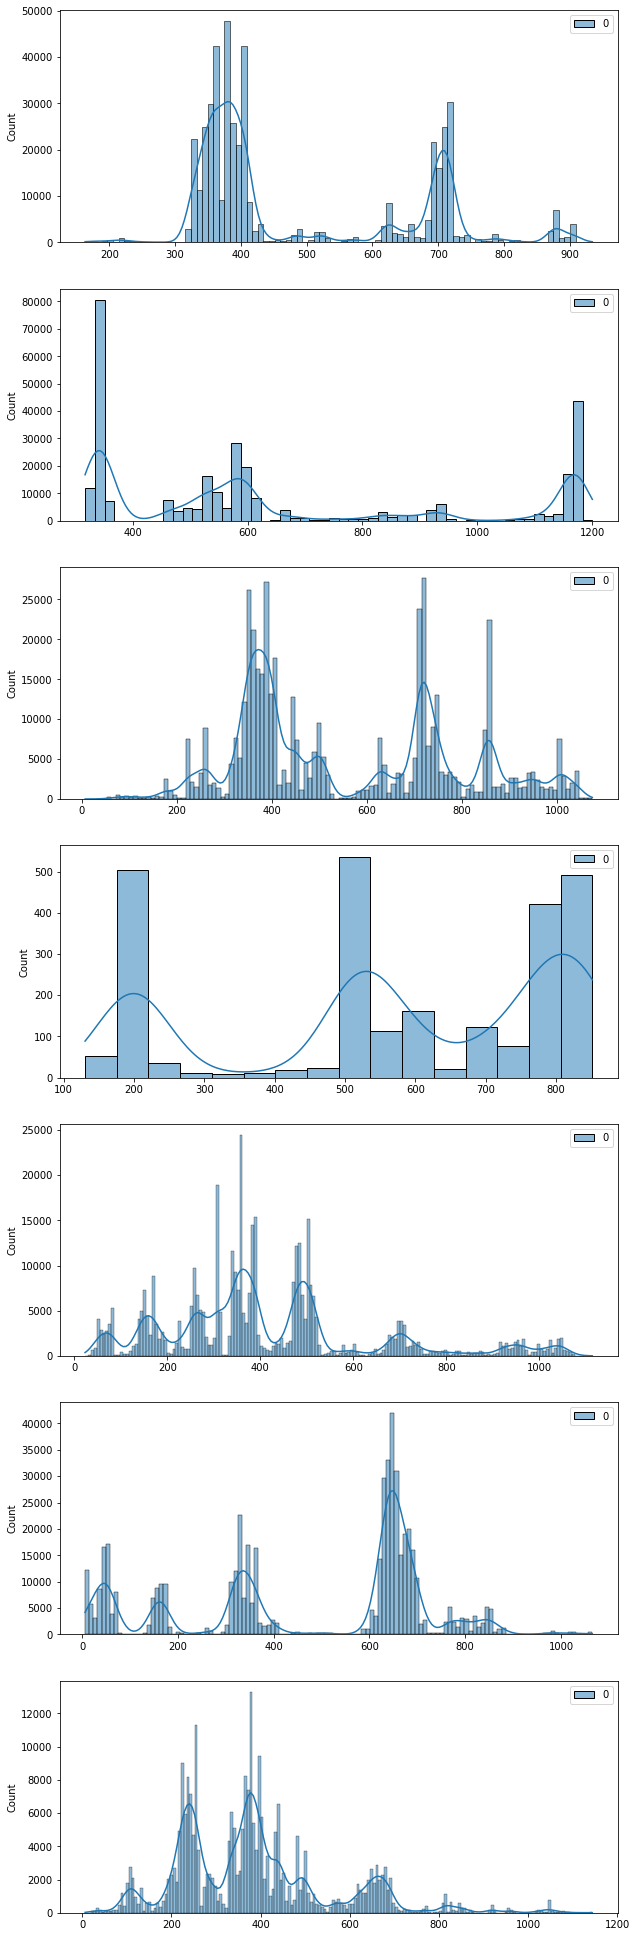

In [188]:
fig, axs = plt.subplots(nrows=7, figsize=(10,5*7))
for i, ax in enumerate(axs):
    dist_df = pd.DataFrame(dists[-7:][i])
    if int(dist_df.notna().sum()) > 0:
        sns.histplot(dist_df, ax=ax, kde=True)

In [147]:
session = -2
info = infos[session]
cent_df = cent_dfs[session]
enter_events = []
exit_events = []

loc = info["session_state"]["reinforced_location"]
r2 = state["params"]["reward_radius"] ** 2
dist2 = ((cent_df.values - loc) ** 2).sum(1)
in_area = dist2 < r2


In [149]:
np.argwhere(in_area == True)

array([[   330],
       [   331],
       [   332],
       ...,
       [733803],
       [733807],
       [733808]])

In [181]:
from moviepy.editor import VideoFileClip
import moviepy.video.fx.all as vfx

last = infos[-1]

In [182]:
top_infos = analysis.find_src_videos(last, "top")

In [186]:
for top_info in top_infos.values():
    clip = VideoFileClip(str(top_info["path"]))
final = clip.fx(vfx.speedx, 15)
final.write_videofile('../analysis/timelapse_pv20_20210719.mp4')

t:   0%|          | 5/19143 [00:00<09:04, 35.16it/s, now=None]

Moviepy - Building video ../analysis/timelapse_pv20_20210719.mp4.
Moviepy - Writing video ../analysis/timelapse_pv20_20210719.mp4



Moviepy - Done !
Moviepy - video ready ../analysis/timelapse_pv20_20210719.mp4


# Video playback timestamps

In [19]:
exp = exps[exps.name=="video_test"].iloc[0]
info = analysis.experiment_info(exp.dir)

In [20]:
info

{'videos': {},
 'csvs': [PosixPath('/data/reptilearn/experiments/video_test_20210724_143326/video_timestamps.csv')],
 'event_log': PosixPath('/data/reptilearn/experiments/video_test_20210724_143326/events.csv'),
 'images': [],
 'session_state': {'is_running': True,
  'experiment': 'video_test',
  'data_dir': '/data/reptilearn/experiments/video_test_20210724_143326',
  'id': 'video_test',
  'start_time': '2021-07-24T14:33:26.368220',
  'params': {'vid_path': '/data/amit/videos/headbobbing1.mp4',
   'background_color': 'black',
   'record_video': False},
  'blocks': [{}],
  'actions': [],
  'cur_block': 0,
  'cur_trial': 0}}

In [30]:
vts_path = info['csvs'][0]
vts_path = "/data/reptilearn/experiments/video_test_20210724_165223/video_timestamps.csv"

In [31]:
vtsdf = pd.read_csv(vts_path, index_col="frame")

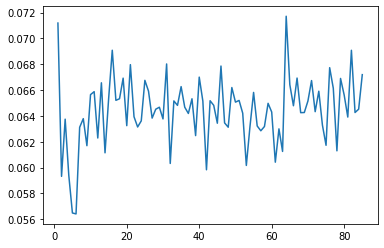

In [33]:
plt.plot(vtsdf.diff())

In [59]:
vtsdf = pd.read_csv("/data/reptilearn/experiments/video_test_20210724_180244/video_timestamps.csv", index_col="frame", parse_dates=True)

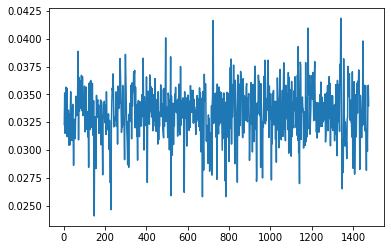

In [60]:
plt.plot(vtsdf.diff())

In [63]:
vtsdf.diff().mean(), vtsdf.diff().std()

(time    0.033253
 dtype: float64,
 time    0.002387
 dtype: float64)

In [49]:
vtsdf.time.values[-1] - vtsdf.time.values[0]

9.68247675895691

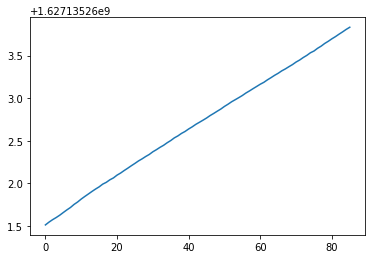

In [64]:
plt.plot(vstdf)